In [1]:
from typing import Optional, List
from importlib import reload

from numpy import sqrt
import pandas as pd

import plotly.express as px
import plotly.io as pio

from data import build_dataset_with_composites, get_factor_master

In [2]:
halflifes = [21, 63, 126, 252]
factor_data = build_dataset_with_composites(halflifes)

[*********************100%%**********************]  55 of 55 completed


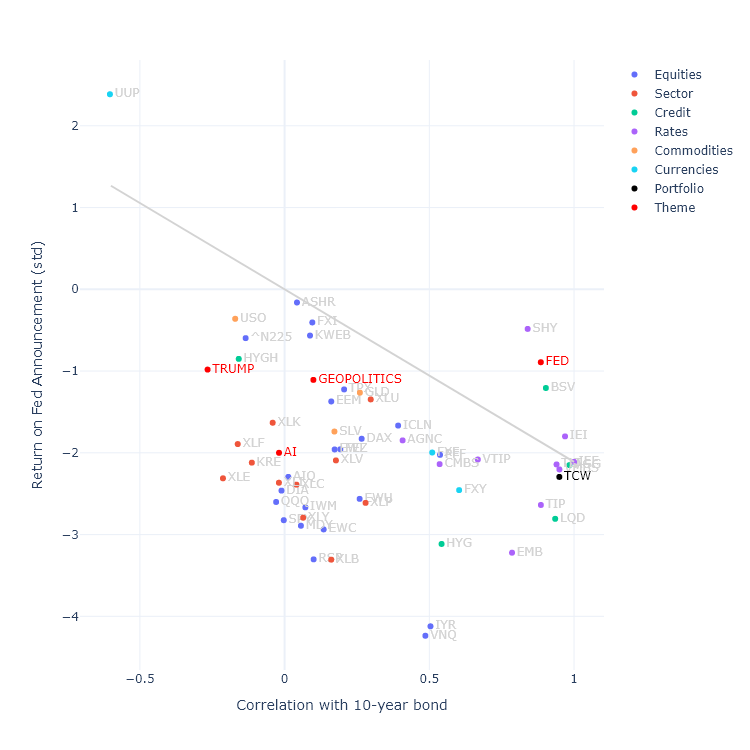

In [3]:
return_date = '2024-12-18'
return_date2 = '2024-12-19'
corr_type = 63
corr_asset = 'IEF'
vol_type = 63

corr = factor_data.corr.shift(date=1).sel(date=return_date, corr_type=corr_type, asset_1=corr_asset).to_series()
vol = factor_data.vol.shift(date=1).sel(date=return_date, vol_type=vol_type).to_series() * sqrt(2 / 252)
ret = (factor_data.ret.sel(date=return_date).to_series() * 100) + (factor_data.ret.sel(date=return_date2).to_series() * 100)
zscore = ret.div(vol).rename('zscore')

factor_master = get_factor_master()

df = (pd.concat([corr, zscore, factor_master.asset_class, factor_master.hyper_factor], axis=1)
      .replace('MWTIX', 'TCW')
      .rename_axis('asset').reset_index()
      .replace('MWTIX', 'TCW')
    #   .assign(size = lambda df: df['hyper_factor'].apply(lambda x: 10 if x == 1 else 1).astype('float'))
      )
# df['textcolor'] = ['black' if asset == 'SPY' else 'lightgray' for asset in df['asset']]

# def override_color_sequence(map):
#     asset_class_list = df.asset_class.unique()
#     color_sequence = pio.templates['plotly_white']['layout']['colorway']
#     color_dict = {a: b for a, b in zip(asset_class_list, color_sequence)}
#     return {**color_dict, **map}

# color_sequence = override_color_sequence({'Portfolio': 'black', 'Theme': 'red'})


def px_scatter(df, x, y, text=None, color=None, size=None, symbol=None, color_sequence_override=None):
    args_format = {'template': 'plotly_white', 'height': 750, 'width': 750}

    # TODO: Refactor to get_color_map() function
    if (color is None) or (color_sequence_override is None):
        color_discrete_map = None
    else:
        color_keys = df[color].unique()
        color_sequence = pio.templates[args_format['template']]['layout']['colorway']
        color_dict = {a: b for a, b in zip(color_keys, color_sequence)}
        color_discrete_map = {**color_dict, **color_sequence_override}

    fig = (px.scatter(df, x=x, y=y, text=text, color=color, size=size, symbol=symbol, 
                      color_discrete_map=color_discrete_map,
                      size_max=20,
                      **args_format)
           .update_traces(textposition='middle right', textfont_color='lightgray')
           .update_layout(legend_title_text=None)
           )

    def get_trace_color(trace, legendgroup):
        return trace.marker.color if trace.legendgroup in legendgroup else 'lightgray'

    asset_class_list = color_sequence_override.keys()
    fig.for_each_trace(lambda t: t.update(textfont_color = get_trace_color(t, asset_class_list)))

    return fig


color_map_override = {'Portfolio': 'black', 
                      'Theme':     'red'}
fig = (px_scatter(df, x='corr', y='zscore', text='asset', color='asset_class', #size='size',
                 color_sequence_override = color_map_override)
       .update_layout(yaxis_title='Return on Fed Announcement (std)',
                      xaxis_title='Correlation with 10-year bond'
                      ))

fig.add_shape(
    type="line",
    x0=df[df['asset'] == 'IEF']['corr'].values[0] * -0.6,
    y0=df[df['asset'] == 'IEF']['zscore'].values[0] * -0.6,
    x1=df[df['asset'] == 'IEF']['corr'].values[0],
    y1=df[df['asset'] == 'IEF']['zscore'].values[0],
    line=dict(color="lightgray", width=2)
)


fig.show(renderer='png')
fig.write_html('fed_feedback.html')
fig.write_html('fed_feedback.png')


# Draw correlation time series

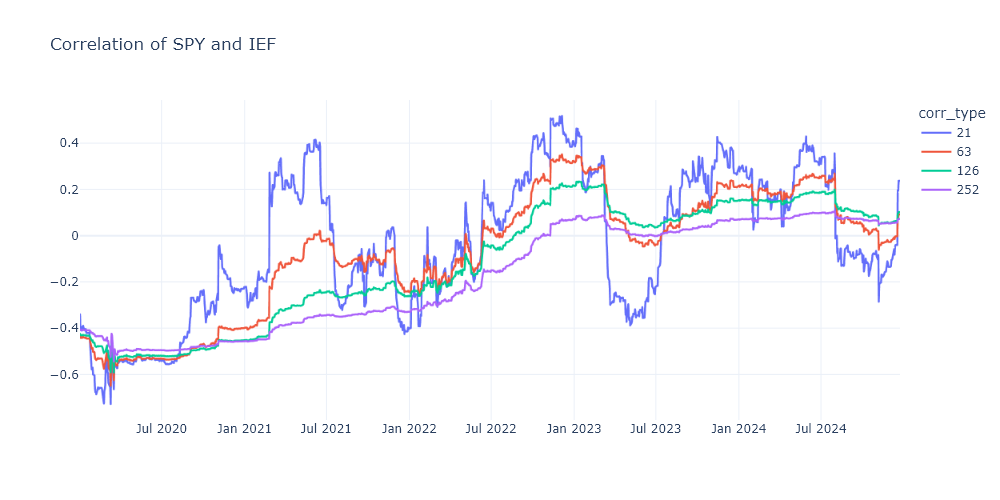

In [4]:
df1  = factor_data.sel(asset='SPY', asset_1='IEF', date=slice('2024', None)).corr.to_pandas().T.stack()

from chart import draw_correlation

fig1 = draw_correlation(factor_data.corr.sel(date=slice('2020', None)), 'SPY', 'IEF', [21, 63, 126, 252])
fig1.show(renderer='png')
fig.write_html('corr_ts.html')
fig.write_html('corr_ts.png')
